In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import pickle
import os
import re

import tensorflow as tf
import tensorflow_hub as hub


import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
root_dir = os.getcwd()
output_path = os.path.join(root_dir, "Output")

file_name = os.path.join(output_path,"president_speeches.pkl")

df = pd.read_pickle(file_name)
df.head()

,filename,president,title,pub_date,speech
0,adams_speeches_000.txt,adams,Special Session Message to Congress,"May 16, 1797",The personal inconveniences to the members of ...
1,adams_speeches_001.txt,adams,Inaugural Address,"March 4, 1797","When it was first perceived, in early times, t..."
2,adams_speeches_002.txt,adams,Second Annual Message,"December 8, 1798",Gentlemen of the Senate and Gentlemen of the H...
3,adams_speeches_003.txt,adams,"Proclamation of Day of Fasting, Humiliation an...","March 23, 1798",As the safety and prosperity of nations ultima...
4,adams_speeches_004.txt,adams,Third Annual Message,"December 3, 1799",It is with peculiar satisfaction that I meet t...


In [3]:
df[df.title == 'Inaugural Address']

,filename,president,title,pub_date,speech
1,adams_speeches_001.txt,adams,Inaugural Address,"March 4, 1797","When it was first perceived, in early times, t..."
23,bharrison_speeches_003.txt,bharrison,Inaugural Address,"March 4, 1889",\nFellow-Citizens:\n\nThere is no constitution...
37,buchanan_speeches_001.txt,buchanan,Inaugural Address,"March 4, 1857",\nFellow-Citizens:\n\nI appear before you this...
51,bush_speeches_001.txt,bush,Inaugural Address,"January 20, 1989","Mr. Chief Justice, Mr. President, Vice Preside..."
77,carter_speeches_004.txt,carter,Inaugural Address,"January 20, 1977","For myself and for our Nation, I want to thank..."
168,coolidge_speeches_003.txt,coolidge,Inaugural Address,"March 4, 1925",\nMy Countrymen:\n\nNo one can contemplate cur...
253,garfield_speeches_000.txt,garfield,Inaugural Address,"March 4, 1881",Fellow-Citizens:\nWe stand to-day upon an emin...
325,harding_speeches_000.txt,harding,Inaugural Address,"March 4, 1921",\nMy Countrymen:\n\nWhen one surveys the world...
343,harrison_speeches_000.txt,harrison,Inaugural Address,"March 4, 1841",Called from a retirement which I had supposed ...
346,hayes_speeches_002.txt,hayes,Inaugural Address,"March 5, 1877",\nFellow-Citizens:\n\nWe have assembled to rep...


#### Tensorflow Universial Sentence Encoder

https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb
    

In [4]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
import os
rootdir = os.getcwd()

#go right to the word embeddings
cache_dir = os.path.join(rootdir,'model')

os.environ["TFHUB_CACHE_DIR"] = cache_dir

# Import the Universal Sentence Encoder's model using TF Hub module
embed = hub.Module(module_url)

In [5]:

#######################################
#Creates a Seaborn correlation heatmap
#######################################
def plot_similarity(labels, features, rotation,mn=0,mx=1,labs=False):
    #corr = np.inner(features, features)
    #xticklabels=False, yticklabels=False
    fig, ax = plt.subplots(figsize=(10,10))  
    sns.set(font_scale=1.2)
    if labs:
        g = sns.heatmap(
          features,
          vmin=mn,
          vmax=mx,
          cmap="Blues",ax=ax)
        g.set_xticklabels(labels, rotation=rotation)
        g.set_yticklabels(labels, rotation=rotation)
    else:
        g = sns.heatmap(
          features,
          xticklabels=False,
          yticklabels=False,
          vmin=mn,
          vmax=mx,
          #cmap="YlOrRd",
          cmap="Blues",
          ax=ax )        
        
    g.set_title("Semantic Textual Similarity")

#######################################
# Run a session with embeded encodings
#######################################
def run_and_plot(session_, input_tensor_, messages_, labels_, encoding_tensor): 
    message_embeddings_ = session_.run(encoding_tensor, feed_dict={input_tensor_: messages_}) 
    plot_similarity(labels_, message_embeddings_, 90) 

In [6]:
documents = df[df.title == 'Inaugural Address']['speech']


In [7]:
# Compute Cosine Similarity based on Term Frequency
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

sparse_matrix = count_vectorizer.fit_transform(documents)

doc_term_matrix = sparse_matrix.todense()

df1 = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=documents.index)



In [8]:
df1

,000,000people,100,13,15th,16,16px,1776,1780,1787,...,yorktown,you,young,younger,your,yours,youth,zeal,zealous,zealously
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
23,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,1,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
51,0,0,0,0,0,0,0,0,0,0,...,0,16,4,0,5,0,0,0,0,0
77,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,0,0,0
168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
253,1,1,0,0,0,0,0,1,1,1,...,1,2,0,0,0,0,0,0,0,0
325,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
343,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,2,0,0,0,0,1
346,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


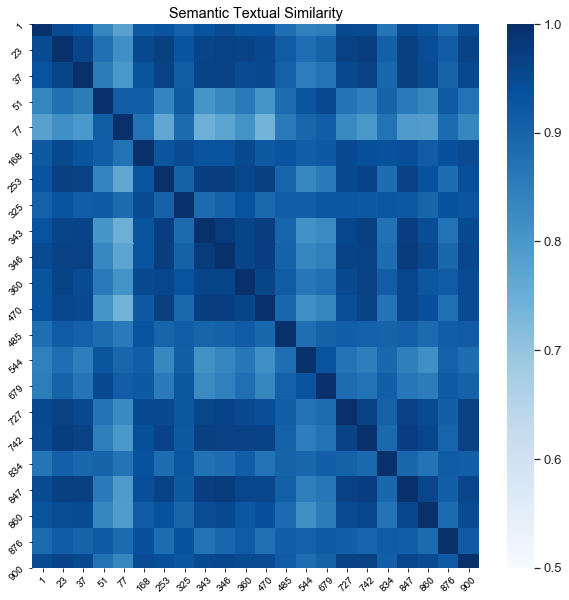

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

cs = cosine_similarity(df1, df1)  

plot_similarity(documents.index, cs, 45, mn=.5, labs=True)

In [10]:
df.iloc[77]

filename                               carter_speeches_004.txt
president                                               carter
title                                        Inaugural Address
pub_date                                      January 20, 1977
speech       For myself and for our Nation, I want to thank...
Name: 77, dtype: object

In [11]:
df.iloc[470]

filename                              jqadams_speeches_000.txt
president                                              jqadams
title                                        Inaugural Address
pub_date                                         March 4, 1825
speech       In compliance with an usage coeval with the ex...
Name: 470, dtype: object

In [12]:
df.iloc[343]

filename                             harrison_speeches_000.txt
president                                             harrison
title                                        Inaugural Address
pub_date                                         March 4, 1841
speech       Called from a retirement which I had supposed ...
Name: 343, dtype: object

In [13]:
all_documents = df['speech']

In [14]:
# Compute Cosine Similarity based on Term Frequency
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

sparse_matrix = count_vectorizer.fit_transform(all_documents)

doc_term_matrix = sparse_matrix.todense()

df2 = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=all_documents.index)

In [15]:
cs2 = cosine_similarity(df2, df2)  

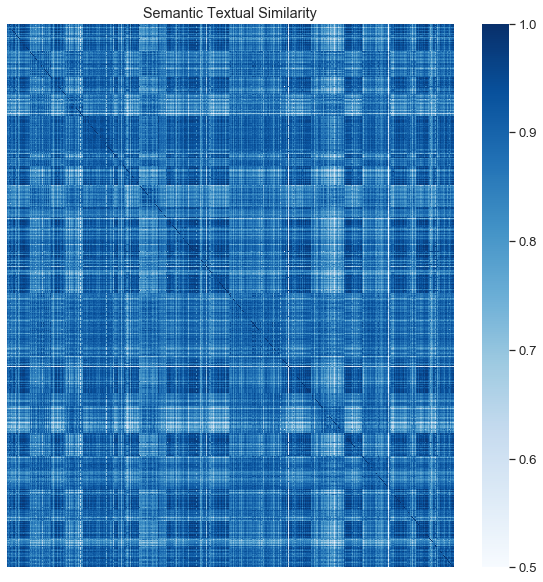

In [16]:
plot_similarity(all_documents.index, cs2, 90, mn=.5, labs=False)

In [17]:
data = pd.DataFrame(cs2)

In [18]:
data

,0,1,2,3,4,5,6,7,8,9,...,952,953,954,955,956,957,958,959,960,961
0,1.000000,0.946842,0.973290,0.909188,0.974003,0.968841,0.920027,0.843348,0.966743,0.927145,...,0.940415,0.856329,0.897682,0.952355,0.915420,0.941708,0.964611,0.955209,0.962452,0.951253
1,0.946842,1.000000,0.934006,0.924874,0.927253,0.938575,0.894367,0.856025,0.921622,0.883469,...,0.934963,0.850084,0.892789,0.942367,0.911511,0.946209,0.938652,0.938764,0.949179,0.929998
2,0.973290,0.934006,1.000000,0.905738,0.977249,0.971646,0.914089,0.861424,0.969033,0.934608,...,0.939515,0.846074,0.891015,0.950698,0.916818,0.942383,0.963255,0.955185,0.966770,0.964606
3,0.909188,0.924874,0.905738,1.000000,0.891195,0.904459,0.850591,0.838088,0.881860,0.831379,...,0.912359,0.805533,0.877058,0.898399,0.866156,0.908714,0.895645,0.901152,0.897311,0.883449
4,0.974003,0.927253,0.977249,0.891195,1.000000,0.966344,0.917019,0.854512,0.967468,0.940022,...,0.924305,0.849013,0.869270,0.942040,0.918425,0.928582,0.957198,0.944075,0.962409,0.961704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,0.941708,0.946209,0.942383,0.908714,0.928582,0.935461,0.887417,0.850559,0.922717,0.885311,...,0.945398,0.834549,0.923685,0.958546,0.910160,1.000000,0.956493,0.966255,0.955349,0.927356
958,0.964611,0.938652,0.963255,0.895645,0.957198,0.958599,0.903645,0.831652,0.956018,0.926284,...,0.956629,0.842408,0.924201,0.970715,0.926568,0.956493,1.000000,0.974700,0.971056,0.958449
959,0.955209,0.938764,0.955185,0.901152,0.944075,0.945433,0.890941,0.837117,0.938570,0.914095,...,0.956100,0.843469,0.938434,0.976654,0.924248,0.966255,0.974700,1.000000,0.962462,0.948254
960,0.962452,0.949179,0.966770,0.897311,0.962409,0.958968,0.914897,0.857925,0.953903,0.930856,...,0.949534,0.853280,0.894302,0.957273,0.935298,0.955349,0.971056,0.962462,1.000000,0.972388
